<a href="https://colab.research.google.com/github/Nate-Shubert/FootballDataAnalysis/blob/main/OLine_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Standard imports
# Change runtime to GPU!
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
fpPlays = '/content/drive/MyDrive/NFL/plays.csv'
dataPlays = pd.read_csv(fpPlays)
fpScout = '/content/drive/MyDrive/NFL/pffScoutingData.csv'
dataScout = pd.read_csv(fpScout)
fpGames = '/content/drive/MyDrive/NFL/games.csv'
dataGames = pd.read_csv(fpGames)
fpW1 = '/content/drive/MyDrive/NFL/week1.csv'
dataW1 = pd.read_csv(fpW1)
fpW2 = '/content/drive/MyDrive/NFL/week2.csv'
dataW2 = pd.read_csv(fpW2)
fpW3 = '/content/drive/MyDrive/NFL/week3.csv'
dataW3 = pd.read_csv(fpW3)
fpW4 = '/content/drive/MyDrive/NFL/week4.csv'
dataW4 = pd.read_csv(fpW4)
fpW5 = '/content/drive/MyDrive/NFL/week5.csv'
dataW5 = pd.read_csv(fpW5)
fpW6 = '/content/drive/MyDrive/NFL/week6.csv'
dataW6 = pd.read_csv(fpW6)
fpW7 = '/content/drive/MyDrive/NFL/week7.csv'
dataW7 = pd.read_csv(fpW7)
fpW8 = '/content/drive/MyDrive/NFL/week8.csv'
dataW8 = pd.read_csv(fpW8)


Using the formula from the Hidden Game of Football, by Bob Carroll - I calcualted the Expected Points Added for the play-by-play dataset.

In [49]:
#Hidden Game of football EPA
def calcEPA(preYdl,postYdl):
  preEP = preYdl*(-2/25) + 6
  postEP = postYdl*(-2/25) + 6
  return postEP - preEP

In [50]:
import math

In [51]:
EPAArray = []
for i in dataPlays.index:
  if dataPlays['passResult'][i] == 'IN':
    EPAArray.append(-4)
  else:
    if math.isnan(dataPlays['absoluteYardlineNumber'][i]):
      if dataPlays['yardlineSide'][i] == dataPlays['possessionTeam'][i]:
        ydlConversion = dataPlays['yardlineNumber'][i] + 50
      else:
        ydlConversion = dataPlays['yardlineNumber'][i]
    else:
      ydlConversion = dataPlays['absoluteYardlineNumber'][i] - 10
    ydsGained = dataPlays['playResult'][i]
    EPAArray.append(calcEPA(ydlConversion,ydlConversion - ydsGained))

dataPlays['EPA'] = EPAArray

In [52]:
dataPlays['EPA'].mean()

0.43630244244478206

After calculating the EPA for each play, I now go through each play and determine if there was a Sack, QB Hit, QB Hurry, or Clean Pocket during that play. 

Through this, I can calculate the average Expected Points Added when any of those events occur. The thought being, through these average EPA values associated with an event, I can isolate an EPA value for specific offensive linement on a play. 

In [53]:
QBHitArr = []
QBHurryArr = []
QBSackArr = []
cleanPocketArr = []
totalPlays = 0
for i in dataPlays.index:
  totalPlays += 1
  id = dataPlays['playId'][i]
  gameid = dataPlays['gameId'][i]
  #Find if that play had a QB Hit
  df_new = dataScout[dataScout['gameId'] == gameid]
  df_new = df_new[df_new['playId'] == id]
  QBHit = False
  QBSack = False
  QBHurry = False
  CLpocket = False
  for j in df_new.index:
    if df_new['pff_sackAllowed'][j] == 1:
      QBSack = True
    elif df_new['pff_hitAllowed'][j] == 1:
      QBHit = True
    elif df_new['pff_hurryAllowed'][j] == 1:
      QBHurry = True
    else:
      CLpocket = True
  if QBSack:
    QBSackArr.append([gameid,id])
    
  elif QBHit:
    QBHitArr.append([gameid,id])
    
  elif QBHurry:
    QBHurryArr.append([gameid,id])
    
  elif CLpocket:
    cleanPocketArr.append([gameid,id])
    

In [54]:
totalQBHits = len(QBHitArr)
SumQBHitEPA = 0
for i in QBHitArr:
  tempdf = dataPlays.loc[(dataPlays['gameId'] == i[0]) & (dataPlays['playId'] == i[1])]
  SumQBHitEPA += tempdf.iloc[0]['EPA']
QBHitAvgEPA = SumQBHitEPA / totalQBHits

In [55]:
totalQBHurry = len(QBHurryArr)
SumQBHurryEPA = 0
for i in QBHurryArr:
  tempdf = dataPlays.loc[(dataPlays['gameId'] == i[0]) & (dataPlays['playId'] == i[1])]
  SumQBHurryEPA += tempdf.iloc[0]['EPA']
QBHurryAvgEPA = SumQBHurryEPA / totalQBHurry

In [56]:
totalQBSack = len(QBSackArr)
SumQBSackEPA = 0
for i in QBSackArr:
  tempdf = dataPlays.loc[(dataPlays['gameId'] == i[0]) & (dataPlays['playId'] == i[1])]
  SumQBSackEPA += tempdf.iloc[0]['EPA']
QBSackAvgEPA = SumQBSackEPA / totalQBSack

In [57]:
totalCleanPockets = len(cleanPocketArr)
SumCleanPockets = 0
for i in cleanPocketArr:
  tempdf = dataPlays.loc[(dataPlays['gameId'] == i[0]) & (dataPlays['playId'] == i[1])]
  SumCleanPockets += tempdf.iloc[0]['EPA']
CPAvgEPA = SumCleanPockets / totalCleanPockets

In [58]:
print(QBHitAvgEPA)
print(QBHurryAvgEPA)
print(QBSackAvgEPA)
print(CPAvgEPA)

0.24046783625730989
0.3689272503082615
-0.5514942528735632
0.5274283832729643


I now have those average values and create a formula that produces and O-line EPA formula. Using this formula, I will go iterate through a list of all possible offensive linemen and the play-by-play data to compile a total EPA for each specific player.

In [59]:
def OlineEPA(hit,hurry,sack,cp):
  return 0.24046783625730989*hit + 0.368927250308261*hurry + -0.5514942528735632*sack + 0.5274283832729643*cp

In [60]:
sackPerPlay = totalQBSack / totalPlays
hurryPerPlay = totalQBHurry / totalPlays
hitPerPlay = totalQBHits / totalPlays
cpPerPlay = totalCleanPockets / totalPlays
avgEPAPerPlay = OlineEPA(hitPerPlay,hurryPerPlay,sackPerPlay,cpPerPlay)
print(avgEPAPerPlay)

0.4363024424447802


In [61]:
epaColArr = []
hitAll = 0
hurryAll = 0
sackAllowed = 0
notBeaten = 0
for i in dataScout.index:
  if dataScout['pff_hitAllowed'][i] == 1:
    hitAll = 1
  elif dataScout['pff_hurryAllowed'][i] == 1:
    hurryAll = 1
  elif dataScout['pff_sackAllowed'][i] == 1:
    sackAllowed = 1
  else:
    notBeaten = 1
  epaColArr.append(OlineEPA(hitAll,hurryAll,sackAllowed,notBeaten))
  hitAll = 0
  hurryAll = 0 
  sackAllowed = 0
  notBeaten = 0

In [62]:
dataScout['EPA'] = epaColArr

In [63]:
dataScout.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,EPA
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527428
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527428
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527428
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527428
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0,0.527428


In [64]:
dfC = dataScout.loc[(dataScout['pff_positionLinedUp'] == 'C')] 
dfRG = dataScout.loc[(dataScout['pff_positionLinedUp'] == 'RG')] 
dfLG = dataScout.loc[(dataScout['pff_positionLinedUp'] == 'LG')] 
dfLT = dataScout.loc[(dataScout['pff_positionLinedUp'] == 'LT')] 
dfRT = dataScout.loc[(dataScout['pff_positionLinedUp'] == 'RT')] 
dfOline = [dfC,dfRG,dfLG,dfLT,dfRT]

In [65]:
dfOline = pd.concat(dfOline)
dfOline = dfOline.reset_index(drop=True)

In [66]:
dfOline

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,EPA
0,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0,0.527428
1,2021090900,137,52554,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,35441.0,PP,0.0,0.527428
2,2021090900,187,52554,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,46081.0,CL,0.0,0.527428
3,2021090900,282,52554,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,42560.0,PA,0.0,0.527428
4,2021090900,349,52554,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,35454.0,PP,0.0,0.527428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42778,2021110100,4310,52504,Pass Block,RT,NaN,NaN,NaN,0.0,0.0,0.0,0.0,53645.0,PP,0.0,0.527428
42779,2021110100,4363,37090,Pass Block,RT,NaN,NaN,NaN,0.0,0.0,0.0,0.0,42406.0,PP,0.0,0.527428
42780,2021110100,4392,37090,Pass Block,RT,NaN,NaN,NaN,0.0,0.0,0.0,0.0,43326.0,PT,0.0,0.527428
42781,2021110100,4411,37090,Pass Block,RT,NaN,NaN,NaN,0.0,0.0,1.0,0.0,42406.0,PP,0.0,0.368927


In [67]:
# list to hold visited values
visited = []
visited2 = []
# loop for counting the unique
# values in height
for i in range(0, len(dfOline['nflId'])):
  if dfOline['nflId'][i] not in visited: 
    visited.append(dfOline['nflId'][i])
    visited2.append(dfOline['pff_positionLinedUp'][i])


In [68]:
te = np.array(visited)
dft = pd.DataFrame(data = te,columns = ['nflId'])
dft['Pos'] = visited2

In [69]:
dft

,nflId,Pos
0,40151,C
1,52554,C
2,52486,C
3,37266,C
4,42392,C
...,...,...
269,44942,RT
270,52635,RT
271,48158,RT
272,53868,RT


In [70]:
# list to hold visited values
v = []
# loop for counting the unique
# values in height
for i in range(0, len(dfOline['nflId'])):
  if dfOline['nflId'][i] == 48158: 
    v.append(dfOline['EPA'][i])

In [71]:
print(v)

[0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.368927250308261, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643, 0.5274283832729643]


In [72]:
playerEPA = 0
playCount = 0
epaArr = []
playCountArr = []
for i in range(0,len(dft['nflId'])):
  for j in range(0, len(dfOline['nflId'])):
    if dfOline['nflId'][j] == dft['nflId'][i]:
      playerEPA += dfOline['EPA'][j]
      playCount += 1
  epaArr.append(playerEPA)
  playCountArr.append(playCount)
  playerEPA = 0
  playerWAR = 0
  playCount = 0

In [73]:
dft['Player EPA'] = epaArr
dft['Downs Played'] = playCountArr

In [74]:
# Create an EPA Per Play 
dft['EPA Per Play'] = dft['Player EPA'] / dft['Downs Played']

In [75]:
dft.sort_values(by=['EPA Per Play'])

,nflId,Pos,Player EPA,Downs Played,EPA Per Play
227,44970,LT,-0.024066,2,-0.012033
272,53868,RT,-0.024066,2,-0.012033
101,45346,RG,0.503363,3,0.167788
267,46323,RT,2.085648,6,0.347608
270,52635,RT,4.909150,14,0.350654
...,...,...,...,...,...
206,44841,LT,0.527428,1,0.527428
119,53543,LG,1.582285,3,0.527428
51,46376,C,1.054857,2,0.527428
114,47880,RG,1.054857,2,0.527428


In [76]:
dft.drop(dft[dft['Downs Played'] <= 50].index, inplace = True)

In [77]:
dft = dft.reset_index(drop=True)

In [78]:
#Average EPA/Play for all linemen
sumPlays = dft['Downs Played'].sum()
sumEPA = dft['Player EPA'].sum()

avgEPA = sumEPA / sumPlays
avgEPA

0.5100179385460909

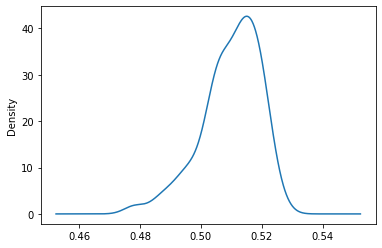

In [79]:
dft['EPA Per Play'].plot(kind='kde')

In [80]:
dft['EPA Above Average'] = dft['EPA Per Play'] - 0.51

In [81]:
#Multiple Average EPA by 60 to get an EPA per 60 plays. Thinking similar to how basketball has "Points Per 100 Possesions"
dft['EPA per 60 Plays'] = dft['EPA Per Play'] * 60

In [82]:
dft

,nflId,Pos,Player EPA,Downs Played,EPA Per Play,EPA Above Average,EPA per 60 Plays
0,40151,C,159.210087,308,0.516916,0.006916,31.014952
1,52554,C,134.737412,261,0.516235,0.006235,30.974118
2,52486,C,149.445867,289,0.517114,0.007114,31.026824
3,37266,C,131.671803,255,0.516360,0.006360,30.981601
4,42392,C,129.879091,251,0.517447,0.007447,31.046795
...,...,...,...,...,...,...,...
200,52938,RT,107.576213,208,0.517193,0.007193,31.031600
201,48220,RT,100.349078,197,0.509386,-0.000614,30.563171
202,52534,RT,68.462907,136,0.503404,-0.006596,30.204224
203,41563,RT,57.336625,111,0.516546,0.006546,30.992770


In [84]:
dft.sort_values(by=['EPA per 60 Plays'])

,nflId,Pos,Player EPA,Downs Played,EPA Per Play,EPA Above Average,EPA per 60 Plays
119,53499,LG,38.194495,80,0.477431,-0.032569,28.645871
142,44943,LT,56.395387,118,0.477927,-0.032073,28.675621
74,52589,RG,41.230606,86,0.479426,-0.030574,28.765539
163,41222,LT,122.150050,252,0.484722,-0.025278,29.083345
162,39947,LT,101.372643,209,0.485037,-0.024963,29.102194
...,...,...,...,...,...,...,...
24,47831,C,42.434738,81,0.523886,0.013886,31.433140
37,42476,C,60.337262,115,0.524672,0.014672,31.480311
18,41390,C,143.881372,274,0.525114,0.015114,31.506870
101,41939,LG,137.582274,262,0.525123,0.015123,31.507391


Next steps:
1. I would like to do an EPA above average analysis on a per position basis. Intial observation shows that Interior Olinemen have a higher EPA per Play. I'm guessing that is because they have less one-on-one pass block scenarios and/or compete less often against top pass rush talent/specialists.

2. I would like to run an analysis to determine the variation and viability of my EPA formula. I would like to find it's accurate because I understand there is high variation in the play-by-play EPA due to other unrelated variables.